# Settings and imports

#### Imports

In [1]:
import sys
sys.path.append('../my_polycomb_utils')

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyBigWig # ChIP-seq signals processing
import bioframe as bf # Genomic intervals processing
from gseapy import Biomart # For databases
from matplotlib_venn import venn2, venn2_circles 

from my_chipseq_untils import parse_gtf_attributes

#### Preparing font

In [5]:
from pathlib import Path
from matplotlib import font_manager

# Downloaded in 01_Polycomb_loops_on_HiC_maps.ipynb
fpath=Path("../fonts/Montserrat-Regular.ttf")
fbpath=Path("../fonts/Montserrat-Bold.ttf")
fe = font_manager.FontEntry(fname=fpath, name='Montserrat')
fbe = font_manager.FontEntry(fname=fbpath, name='Montserrat', style='bold', variant='bols', weight='bold')
font_manager.fontManager.ttflist.insert(0, fbe)
font_manager.fontManager.ttflist.insert(0, fe) # or append is fine
font_manager.fontManager.addfont(fbpath)
font_manager.fontManager.addfont(fpath)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Montserrat']

#### Settings

In [6]:
# Set-up suppression of some varnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [7]:
data_dir = '../data/'

## 00: Load and preprocess ChIP-seq data

##### Load peaks

The raw data can be obtained from GEO under the accesions GSM6585894, GSM6585906, GSM6585909, GSM6585897, GSM6585907, GSM6585910

In [8]:
cts = ['mES', 'NPC']
proteins = ['H3K27me3', 'RYBP', 'YAF2']
chroms = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10',
          'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']

In [9]:
peaks = dict()
for ct in cts:
    peaks[ct] = dict()
    for protein in proteins:
        file = [f for f in os.listdir(data_dir) if (ct in f and protein in f and 'broadPeak' in f)][0]
        print(file.split('_')[0].rstrip('.broadPeak'), ': ', file.split('_', 1)[1].rstrip('.broadPeak'))
        peaks[ct][protein] = bf.read_table(data_dir + file, schema='broadPeak')
        peaks[ct][protein] = peaks[ct][protein].query('not chrom.isin(["chrX", "chrY"])')
        peaks[ct][protein] = peaks[ct][protein] \
                                               .sort_values(by=['start', 'end'])\
                                               .sort_values(by=['chrom'], 
                                                            kind='stable',
                                                            key=lambda x: x.str.removeprefix('chr').astype('int'))
        

GSM6585894 :  H3K27me3_mES_WT_peaks
GSM6585906 :  mES_RYBP_peaks
GSM6585909 :  mES_YAF2_peaks
GSM6585897 :  H3K27me3_NPC_WT_peaks
GSM6585907 :  NPC_WT_RYBP_peaks
GSM6585910 :  NPC_WT_YAF2_peaks


##### Load reference

```bash
cd data
wget --no-check-certificate https://hgdownload.soe.ucsc.edu/goldenpath/mm10/bigZips/genes/mm10.ensGene.gtf.gz
```

In [10]:
mm_annot_fpath  = 'mm10.ensGene.gtf.gz'
mm_annot = bf.read_table(data_dir + mm_annot_fpath, schema='gtf')
mm_annot_attr = parse_gtf_attributes(mm_annot['attributes'], kv_sep=" ")
mm_annot['gene_id'] = mm_annot_attr['gene_id']
mm_annot = mm_annot.drop(columns='attributes')
mm_annot = mm_annot.query('chrom.isin(@chroms)')

##### Get genes promoters

In [12]:
TSSs = mm_annot.copy()
TSSs[['start', 'end']] = TSSs.apply(lambda x: [x.start - 1000, x.start + 100] if x.strand == '+' else [x.end - 100, x.end + 1000], 
                                    axis=1, result_type='expand')
TSSs = TSSs.dropna(subset='gene_id')

##### Overlap peaks with promoters

In [13]:
for ct in cts:
    for protein in proteins:
        initial_cols = peaks[ct][protein].columns.to_list()
        peaks[ct][protein] = bf.overlap(peaks[ct][protein], TSSs, how='left')[initial_cols+['gene_id_',]].fillna({'gene_id_':'nan'}).groupby(initial_cols).agg(list).reset_index()

# 01: RYBP/YAF2 ChIP-seq comparison

**Figures in thesis:**
- `Figure 14`: (I) Vienn diagrams, (II) TSS signals, (III) TSS signal scatterplot

### _01 (I) Vienn diagrams

In [14]:
overlaps = {}
for ct in cts:
    overlaps[ct] = bf.overlap(peaks[ct]['RYBP'],
                              peaks[ct]['YAF2'], 
                              suffixes=('_RYBP','_YAF2'),
                              how='outer'
                             )
    print(ct, peaks[ct]['RYBP'].shape[0], peaks[ct]['YAF2'].shape[0], overlaps[ct].shape[0])

mES 14076 900 14121
NPC 11739 7318 12590


/tmp/ipykernel_78159/2255707581.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  overlaps_sizes = (overlaps_sizes_df.loc[True,].loc[False,][0],
/tmp/ipykernel_78159/2255707581.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  overlaps_sizes_df.loc[False,].loc[True,][0],
/tmp/ipykernel_78159/2255707581.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  overlaps_sizes_df.loc[True,].loc[True,][0])
/tmp/ipykernel_78159/2255707581.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  overlaps_sizes = (overlaps_sizes_df.loc[True,].loc[False,][0],
/tmp/ipykernel_78159/2255707581.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  overlaps_sizes_df.loc[False,].loc[True,][0],
/tmp/ipykernel_78159/2255707581.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  overlaps_sizes_df.loc[True,].loc[True,][0])


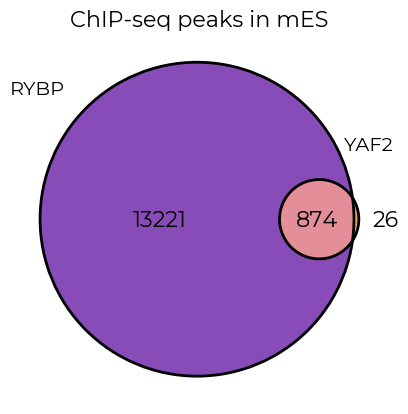

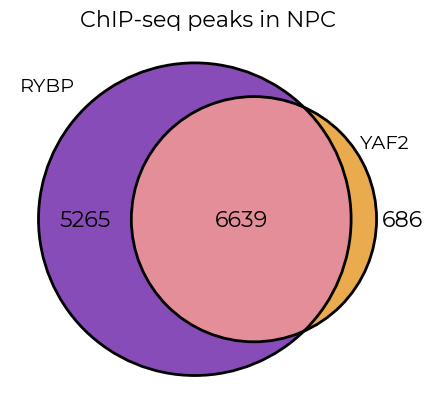

In [16]:
for ct in cts:
    overlaps_sizes_df = overlaps[ct][['name_RYBP', 'name_YAF2']].notna().value_counts().to_frame()
    # https://github.com/pandas-dev/pandas/issues/47687
    overlaps_sizes = (overlaps_sizes_df.loc[True,].loc[False,][0], 
                      overlaps_sizes_df.loc[False,].loc[True,][0], 
                      overlaps_sizes_df.loc[True,].loc[True,][0])
    
    fig = plt.figure()
    vd = venn2(subsets = overlaps_sizes, 
               alpha=0.7,
               set_labels = ('RYBP', 'YAF2'), 
               set_colors=("#56009c", "#e08803")
              ) 
    venn2_circles(subsets=overlaps_sizes) 

    for text in vd.set_labels:
        text.set_fontsize(14)
    for text in vd.subset_labels:
        text.set_fontsize(16)


    vd.get_label_by_id("A").set_position((-0.5, 0.5))
    vd.get_label_by_id("B").set_position((0.5, 0.3))
    vd.get_label_by_id("01").set_position((0.65, 0))
    
    plt.title(f'ChIP-seq peaks in {ct}', fontsize=16)

### _01 (II) TSS signals

##### Get mouse ortologs of human Polycomb-targeted genes by Biomart

In [20]:
bm = Biomart()

In [27]:
polycomb_anchors = pd.read_table(data_dir + "polycomb_anchors_nick_anno_500bp_promoter.tsv", sep='\t')
polycomb_anchors = polycomb_anchors.dropna(subset='gene_id_anno')
genes = sum([[genes] if (';' not in str(genes)) else genes.split(';') for genes in polycomb_anchors.gene_id_anno.tolist() ], [])
genes = [gene.split('.')[0] for gene in genes]

In [23]:
m2h = bm.query(dataset='mmusculus_gene_ensembl',
               attributes=['ensembl_gene_id','external_gene_name',
                           'hsapiens_homolog_ensembl_gene',
                           'hsapiens_homolog_associated_gene_name'])

h2m = bm.query(dataset='hsapiens_gene_ensembl',
               attributes=['ensembl_gene_id','external_gene_name',
                           'mmusculus_homolog_ensembl_gene',
                           'mmusculus_homolog_associated_gene_name'])

In [25]:
mm_genes = h2m.query('ensembl_gene_id.isin(@genes)').dropna(subset='mmusculus_homolog_ensembl_gene').mmusculus_homolog_ensembl_gene.to_list()

In [26]:
print(len(genes)), print(len(set(mm_genes)));

356
164


##### Get their TSSs

In [35]:
mm_annot_orts = mm_annot.query('feature=="start_codon"').drop_duplicates(subset=['gene_id']).query('gene_id.isin(@mm_genes)')
mm_annot_orts['TSS'] = mm_annot_orts.apply(lambda x: x.start if x.strand == '+' else x.end, axis=1, result_type='expand')

In [36]:
lost_ids = set(mm_genes) - set(mm_annot_orts.gene_id)
print(len(lost_ids))

23


In [37]:
mm_annot_orts = mm_annot_orts.set_index('gene_id', drop=False).join(m2h.set_index('ensembl_gene_id')[['hsapiens_homolog_associated_gene_name']]).drop_duplicates(subset='gene_id')
mm_annot_orts = mm_annot_orts.set_index('hsapiens_homolog_associated_gene_name')

##### Get signal around these genes

In [38]:
bws = {
    'mES': {
            'RYBP': 'GSM6585906_mES_RYBP_nor.bw',
            'YAF2': 'GSM6585909_mES_YAF2_nor.bw',
            'H3K27me3': 'GSM6585894_H3K27me3_46C_WT.bw'
    },
    'NPC': {
            'RYBP': 'GSM6585907_NPC_WT_RYBP_nor.bw',
            'YAF2': 'GSM6585910_NPC_WT_YAF2_nor.bw',
            'H3K27me3': 'GSM6585897_H3K27me3_NPC_WT.bw'
    }
}

In [39]:
mm_annot_orts.index = np.where(mm_annot_orts.index.duplicated(), 
                               mm_annot_orts.index + '_' + mm_annot_orts.groupby('hsapiens_homolog_associated_gene_name').cumcount().astype('str'), 
                               mm_annot_orts.index)

In [42]:
FLANK = 5000

signals = {}
signals_means = {}
for ct in cts:
    signals[ct] = {}
    signals_means[ct] = {}
    for protein in proteins:
        bw = pyBigWig.open("/home/nvaulin/wd/chipseq_mm10_PRC1_NatComm_07_2023/" + bws[ct][protein])    
        mm_annot_orts['signal'] = mm_annot_orts.apply(lambda x: bw.values(x.chrom, x.TSS - FLANK, x.TSS + FLANK), axis=1)
        signals[ct][protein] = pd.DataFrame(np.array(mm_annot_orts.signal.to_list()), index=mm_annot_orts.index)
        signals_means[ct][protein] = mm_annot_orts.signal.apply(np.mean)

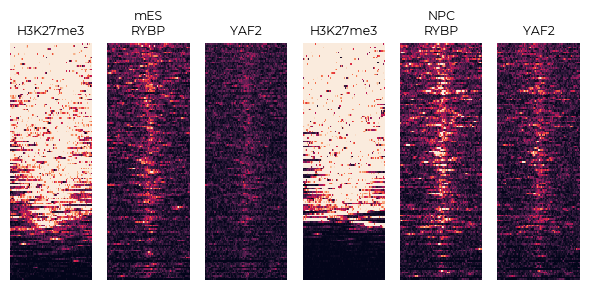

In [43]:
fig, axs = plt.subplots(ncols=6, figsize=(6, 3), layout='tight')

i = 0
for ct in cts:
    for protein in proteins:

        genes_order = signals_means[ct]['H3K27me3'].sort_values(ascending=False).index.values

        stacked_signal = signals[ct][protein].loc[genes_order]

        ax = axs[i]
        sns.heatmap(stacked_signal,
                    xticklabels=False,
                    yticklabels=False, 
                    vmin=0, vmax=15,
                    cbar = False,#cbar_kws=dict(use_gridspec=False,location="top", aspect=50),
                    ax=ax
                   )
        ax.set_ylabel('')
        if protein == 'RYBP':   
            ax.set_title(f'{ct}\n{protein}', size=9)
        else:
            ax.set_title(f'{protein}', size=9)
        i += 1


Text(0.5, 0.98, 'Mice orthologs of genes in Polycomb\nloops anchors, TSS +- 5000 bp')

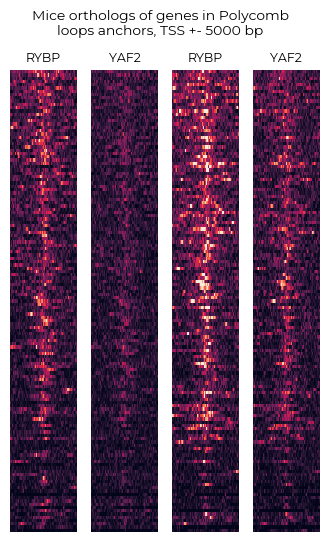

In [45]:
fig, axs = plt.subplots(ncols=4, figsize=(4, 6), dpi=100)

i = 0
for ct in cts:
    for protein in proteins:
        if protein == 'H3K27me3':
            continue

        genes_order = signals_means[ct]['H3K27me3'].sort_values(ascending=False).index.values
        stacked_signal = signals[ct][protein].loc[genes_order]

        ax = axs[i]
        sns.heatmap(stacked_signal,
                    xticklabels=False,
                    yticklabels=False, 
                    vmin=0, vmax=15,
                    cbar = False,#cbar_kws=dict(use_gridspec=False,location="top", aspect=50),
                    ax=ax
                   )
        ax.set_ylabel('')
        ax.set_title(f'{protein}', size=9)

        i += 1

plt.suptitle(f'Mice orthologs of genes in Polycomb\nloops anchors, TSS +- {FLANK} bp', size=10)


### _01  (III) TSS signal scatterplot

In [47]:
genes_order = signals_means['NPC']['H3K27me3'].sort_values(ascending=False).index.values

mean_tss_signals = pd.DataFrame([signals[ct][protein].loc[genes_order].mean(axis=1).to_list() for ct in cts for protein in proteins],
                                 index = [f'{ct}_{protein}' for ct in cts for protein in proteins],
                                 columns = genes_order
                                ).T

mean_tss_signals = mean_tss_signals.sort_values(by='NPC_YAF2', ascending=False)

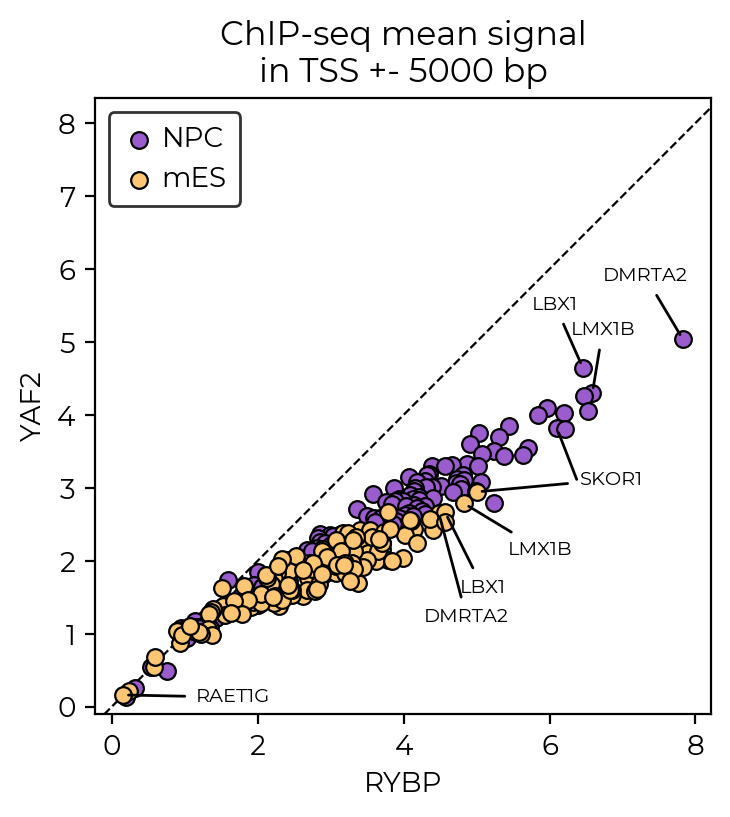

In [48]:
fig = plt.figure(figsize=(4,4), dpi=200)


x = 'RYBP'
y = 'YAF2'


to_annot = pd.concat([mean_tss_signals.head(3), mean_tss_signals.tail(1), mean_tss_signals.sort_values('mES_RYBP').tail(1)], axis=0)


for ct, color in zip(['NPC', 'mES'], ['#9b5cce', '#fcc674']):
    ax = sns.scatterplot(mean_tss_signals,
                y=f'{ct}_{y}',
                x=f'{ct}_{x}', 
                linewidth=0.8, edgecolor='k',
                color=color, label=ct
               )
    
for ct in ['mES', 'NPC']:
    for i, (gene, data) in enumerate(to_annot.iterrows()):
        if ct  == 'NPC' and gene == 'RAET1G':
            continue
        x_coord = data[f'{ct}_{x}']
        y_coord = data[f'{ct}_{y}']
        offset_x = 1.4-0.4*(3-i+1) if ct =='mES' else .5-0.4*(3-i+1)
        offset_y = (10.5-0.4*(30-i) if ct =='mES' else +0.8) + 0.2*(gene == 'RAET1G')
        x_text = x_coord + offset_x
        y_text = y_coord + offset_y
        if ct  == 'mES' and gene == 'SKOR1':
            x_skor, y_skor = x_text, y_text
        if ct  == 'NPC' and gene == 'SKOR1':
            gene = ''
            x_text, y_text = x_skor, y_skor
            
        plt.annotate(text = gene,
                     xy = (x_coord, y_coord),
                     xytext = (x_text, y_text),
                     arrowprops=dict(facecolor='black', arrowstyle='-'),
                     fontsize=7)

legend  = plt.legend(loc='upper left', frameon=1, 
                    handlelength=1.2, handletextpad=0.2,
                    borderpad=0.5, labelspacing=0.5)
legend.legendPatch.set_edgecolor("k")
legend.legendPatch.set_linewidth(1)


plt.axis('square')
plt.title(f'ChIP-seq mean signal\nin TSS +- {FLANK} bp')
plt.ylabel(y)
plt.xlabel(x)
plt.gca().axline([0, 0], [1, 1], 
                color='k', linewidth=0.8, linestyle='--', zorder=-1)